### Retinex model based stain normalization technique for whole slide image analysis 논문 기반에서 조금 보완 진행해봄
* illumination map의 gradient에서 절대값 제거
* 조정 된 illumination map에 minmax normalization 진행
* Optical density를 구하는 과정에서 normalization을 진행하는 것이 맞을까? (skimage에서 이렇게 진행함, OD 구하는 공식과 다름) -> OD를 구하는 원 공식대로 진행
* 현재 stain matrix는 H&E, DAB 값을 사용 중 H&E만 사용 해보는 것을 시도(다만, 염색약이 2개 뿐이라 stain matrix가 2x3라 역행렬을 구할 수가 없음. 그렇기 때문에 우의사역행렬을 이용)

In [2]:
import os
import yaml
from pathlib import Path
from PIL import Image
from scipy import linalg
from scipy.ndimage import gaussian_filter

import numpy as np
import skimage
import matplotlib.pyplot as plt
from openslide import OpenSlide

from src.utils import *
from src.wsi_reader import WSIReader
from src.transformer import *

In [3]:
config = load_config()
config

{'dataset_path': '/Users/cmkim/workspace/datasets/TIGER/'}

In [4]:
image = WSIReader(
    path=Path(config["dataset_path"]) / "wsibulk/images" / "119S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "103S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "144S.tif"
    # path=Path(config["dataset_path"]) / "wsibulk/images" / "111S.tif"
).read_array(
    level=32
)

In [8]:
od_transformer = OpticalDensityScaleTransformer()
od = od_transformer.transform(image)

In [9]:
stain_vector = StainSpecficVector.he()
stain_vector

array([[0.644211, 0.716556, 0.266844],
       [0.092789, 0.954111, 0.283111]])

In [10]:
stains = ColorDeconvolution().separate(od, stain_vector)
stains

array([[[0.06523306, 0.01047773],
        [0.06523306, 0.01047773],
        [0.06523306, 0.01047773],
        ...,
        [0.06601085, 0.00909058],
        [0.07249002, 0.00412704],
        [0.07249002, 0.00412704]],

       [[0.06523306, 0.01047773],
        [0.06523306, 0.01047773],
        [0.06523306, 0.01047773],
        ...,
        [0.06601085, 0.00909058],
        [0.07249002, 0.00412704],
        [0.07249002, 0.00412704]],

       [[0.06523306, 0.01047773],
        [0.06523306, 0.01047773],
        [0.06523306, 0.01047773],
        ...,
        [0.06601085, 0.00909058],
        [0.07249002, 0.00412704],
        [0.07249002, 0.00412704]],

       ...,

       [[0.05994313, 0.00904782],
        [0.05994313, 0.00904782],
        [0.05994313, 0.00904782],
        ...,
        [0.06601085, 0.00909058],
        [0.07249002, 0.00412704],
        [0.07249002, 0.00412704]],

       [[0.07557147, 0.00412734],
        [0.07557147, 0.00412734],
        [0.07557147, 0.00412734],
        .

In [11]:
stains.max(), stains.min()

(np.float64(2.804137181900573), np.float64(-0.04957342098387733))

### illumination map

In [12]:
# tmap = np.max(stains, axis=2)
tmap = np.mean(stains, axis=2)
tmap

array([[0.03785539, 0.03785539, 0.03785539, ..., 0.03755072, 0.03830853,
        0.03830853],
       [0.03785539, 0.03785539, 0.03785539, ..., 0.03755072, 0.03830853,
        0.03830853],
       [0.03785539, 0.03785539, 0.03785539, ..., 0.03755072, 0.03830853,
        0.03830853],
       ...,
       [0.03449547, 0.03449547, 0.03449547, ..., 0.03755072, 0.03830853,
        0.03830853],
       [0.0398494 , 0.0398494 , 0.0398494 , ..., 0.04218372, 0.04295147,
        0.04295147],
       [0.03677435, 0.03677435, 0.03677435, ..., 0.03755072, 0.03830853,
        0.03830853]], shape=(1356, 1736))

In [13]:
tmap_gradh = np.gradient(tmap, axis=1)
tmap_gradv = np.gradient(tmap, axis=0)

In [14]:
epsilon = 1e-4
sigma = 6

In [15]:
gaussian = gaussian_filter(tmap, sigma=sigma)
gaussian

array([[0.03790327, 0.03790928, 0.0379214 , ..., 0.0377329 , 0.03774294,
        0.03774816],
       [0.03790192, 0.03790783, 0.03791973, ..., 0.0377329 , 0.03774294,
        0.03774816],
       [0.03789921, 0.03790491, 0.03791639, ..., 0.0377329 , 0.03774294,
        0.03774816],
       ...,
       [0.03822633, 0.03821766, 0.0382006 , ..., 0.03867115, 0.03867508,
        0.0386772 ],
       [0.0382064 , 0.03819796, 0.03818138, ..., 0.03871243, 0.03871624,
        0.03871829],
       [0.03819571, 0.03818741, 0.03817108, ..., 0.03873388, 0.03873762,
        0.03873965]], shape=(1356, 1736))

In [16]:
wh = np.sum(gaussian / (gaussian * tmap_gradh + epsilon), axis=1, keepdims=True)
wv = np.sum(gaussian / (gaussian * tmap_gradv + epsilon), axis=0, keepdims=True)

In [17]:
wh, wv

(array([[448313.76848994],
        [383891.95412015],
        [342593.44461478],
        ...,
        [722867.89154251],
        [702232.08583902],
        [710085.67811414]], shape=(1356, 1)),
 array([[304312.27052726, 201180.68882561, 251707.84323687, ...,
         558659.37846314, 571362.55664168, 585301.03766444]],
       shape=(1, 1736)))

In [18]:
tmap_adj = tmap / (wh + wv + epsilon)
tmap_adj

array([[5.02977480e-08, 5.82844002e-08, 5.40774659e-08, ...,
        3.72906826e-08, 3.75693061e-08, 3.70626773e-08],
       [5.50060484e-08, 6.47020423e-08, 5.95585383e-08, ...,
        3.98394387e-08, 4.01029585e-08, 3.95262165e-08],
       [5.85176386e-08, 6.96160272e-08, 6.36973125e-08, ...,
        4.16650190e-08, 4.19150725e-08, 4.12854400e-08],
       ...,
       [3.35826905e-08, 3.73308008e-08, 3.53953749e-08, ...,
        2.93015349e-08, 2.95994674e-08, 2.92840864e-08],
       [3.95903112e-08, 4.41098526e-08, 4.17734944e-08, ...,
        3.34554755e-08, 3.37245980e-08, 3.33595047e-08],
       [3.62523939e-08, 4.03552192e-08, 3.82351858e-08, ...,
        2.95967388e-08, 2.98947168e-08, 2.95730468e-08]],
      shape=(1356, 1736))

In [19]:
tmap_adj = (tmap_adj - np.min(tmap_adj)) / (np.max(tmap_adj) - np.min(tmap_adj))
tmap_adj

array([[0.60548973, 0.60548973, 0.60548973, ..., 0.60548972, 0.60548972,
        0.60548971],
       [0.60548973, 0.60548974, 0.60548973, ..., 0.60548972, 0.60548972,
        0.60548972],
       [0.60548973, 0.60548974, 0.60548974, ..., 0.60548972, 0.60548972,
        0.60548972],
       ...,
       [0.60548971, 0.60548972, 0.60548971, ..., 0.60548971, 0.60548971,
        0.60548971],
       [0.60548972, 0.60548972, 0.60548972, ..., 0.60548971, 0.60548971,
        0.60548971],
       [0.60548971, 0.60548972, 0.60548972, ..., 0.60548971, 0.60548971,
        0.60548971]], shape=(1356, 1736))

In [20]:
stains_adj = stains * tmap_adj[..., np.newaxis]
stains_adj = stains_adj + stains_adj * (1-tmap_adj[..., np.newaxis])
stains_adj

array([[[0.0550803 , 0.00884699],
        [0.0550803 , 0.00884699],
        [0.0550803 , 0.00884699],
        ...,
        [0.05573703, 0.00767574],
        [0.06120779, 0.00348472],
        [0.06120779, 0.00348472]],

       [[0.0550803 , 0.00884699],
        [0.0550803 , 0.00884699],
        [0.0550803 , 0.00884699],
        ...,
        [0.05573703, 0.00767574],
        [0.06120779, 0.00348472],
        [0.06120779, 0.00348472]],

       [[0.0550803 , 0.00884699],
        [0.0550803 , 0.00884699],
        [0.0550803 , 0.00884699],
        ...,
        [0.05573703, 0.00767574],
        [0.06120779, 0.00348472],
        [0.06120779, 0.00348472]],

       ...,

       [[0.05061368, 0.00763963],
        [0.05061368, 0.00763963],
        [0.05061368, 0.00763963],
        ...,
        [0.05573703, 0.00767574],
        [0.06120779, 0.00348471],
        [0.06120779, 0.00348471]],

       [[0.06380965, 0.00348497],
        [0.06380965, 0.00348497],
        [0.06380965, 0.00348497],
        .

In [21]:
null = np.zeros_like(stains[:, :, 0])

In [22]:
hematoxylin = skimage.color.hed2rgb(np.stack((stains[:, :, 0], null, null), axis=-1))
eosin = skimage.color.hed2rgb(np.stack((null, stains[:, :, 1], null), axis=-1))
# dab = skimage.color.hed2rgb(np.stack((null, null, stains[:, :, 2]), axis=-1))

In [23]:
hematoxylin_adj = skimage.color.hed2rgb(np.stack((stains_adj[:, :, 0], null, null), axis=-1))
eosin_adj = skimage.color.hed2rgb(np.stack((null, stains_adj[:, :, 1], null), axis=-1))
# dab_adj = skimage.color.hed2rgb(np.stack((null, null, stains_adj[:, :, 2]), axis=-1))

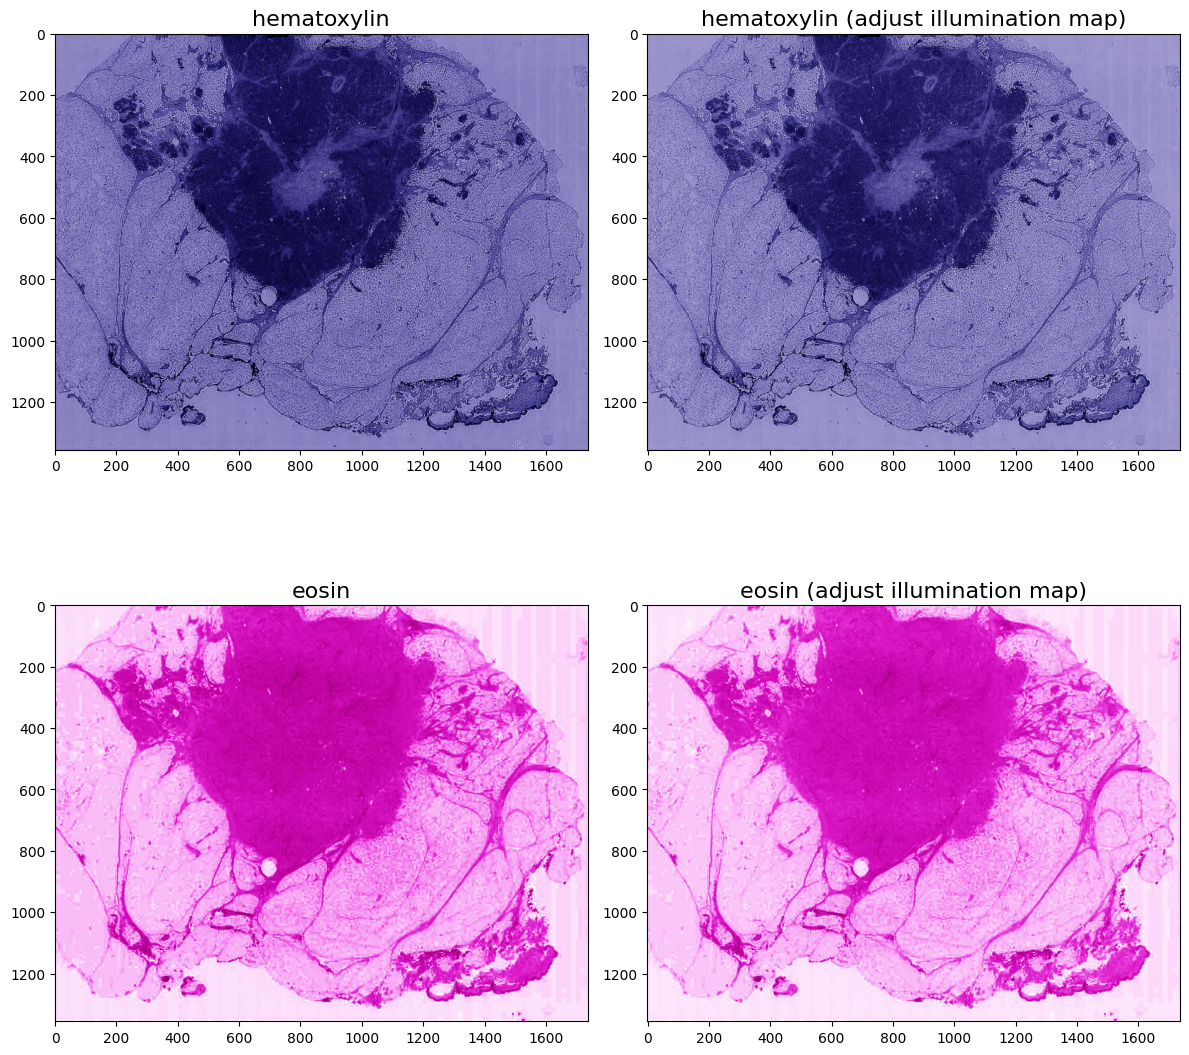

In [24]:
fontdict={
    "fontsize": 16
}

fig = plt.figure(figsize=(12, 12))

ax = fig.add_subplot(221)
ax.imshow(hematoxylin)
ax.set_title(label="hematoxylin", fontdict=fontdict)

ax = fig.add_subplot(222)
ax.imshow(hematoxylin_adj)
ax.set_title(label="hematoxylin (adjust illumination map)", fontdict=fontdict)

ax = fig.add_subplot(223)
ax.imshow(eosin)
ax.set_title(label="eosin", fontdict=fontdict)

ax = fig.add_subplot(224)
ax.imshow(eosin_adj)
ax.set_title(label="eosin (adjust illumination map)", fontdict=fontdict)

fig.tight_layout()
plt.show()

### Recover

In [25]:
image_adj = stain_combine(stains_adj, stain_vector)

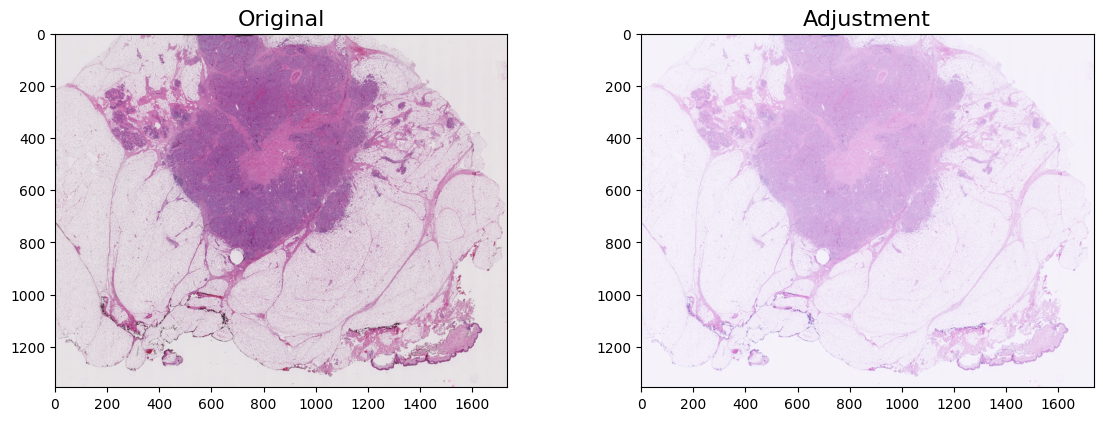

In [27]:
fontdict={
    "fontsize": 16
}

fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(221)
ax.imshow(image)
ax.set_title(label="Original", fontdict=fontdict)

ax = fig.add_subplot(222)
ax.imshow(image_adj)
ax.set_title(label="Adjustment", fontdict=fontdict)

fig.tight_layout()
plt.show()